# **Part 1: Logistic Regression - Set Up**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
def accuracy(pred, actual):
  count = 0
  for i in range(len(pred)):
    if pred[i] == actual[i]:
      count += 1
  return count / len(actual)

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000] 
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:] 

In [ ]:
three_and_seven = np.logical_or(mnist_training_labels=='3', mnist_training_labels == '7')
mnist_training_label_lucky = np.expand_dims(1.0*(np.logical_or(three_and_seven, mnist_training_labels == '8')),1)

test_three_and_seven = np.logical_or(mnist_testing_labels=='3', mnist_testing_labels == '7')
mnist_testing_label_lucky = np.expand_dims(1.0*(np.logical_or(test_three_and_seven, mnist_testing_labels == '8')),1)

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_lucky)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_lucky)


In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution 
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution 
  test_loss = 0
  num_batches = 0
  with torch.no_grad(): 
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss


In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):                           
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
      
  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()          
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)
    
    def forward(self, x):           
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)     
        return x

In [ ]:
def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

In [ ]:
def lucky_accuracy(model, test, label):
  correct = 0
  for i in range(len(test)):
      with torch.no_grad():
        output = model(torch.Tensor([test[i]]))
        correct += (output>0).eq(label[i]>0).sum()
        print(output)
        print(label[i])
  return correct / len(test)

In [ ]:
mnist_testing_label_is_three = np.expand_dims(1.0*(mnist_testing_labels=='3'),1)
mnist_testing_label_is_seven = np.expand_dims(1.0*(mnist_testing_labels=='7'),1)
mnist_testing_label_is_eight = np.expand_dims(1.0*(mnist_testing_labels=='8'),1)

testing_dataset_3 = NumpyDataset(mnist_testing_data,mnist_testing_label_is_three)
testing_dataset_7 = NumpyDataset(mnist_testing_data,mnist_testing_label_is_seven)
testing_dataset_8 = NumpyDataset(mnist_testing_data,mnist_testing_label_is_eight)

# **Part 1: Logistic Regression - Results**

I trained my model on a dataset that had a label for 1 if the number was 3, 7 or 8. I also split it into training and testing to better train. 

Quality of model:

*   Train Set: Accuracy: 51786/60000 (86.3%)
*   Test Set: Accuracy: 8604/10000 (86.0%)

In terms of which numbers were the best:

* Test Set on 3's: Accuracy: 8142/10000 (81.4%)

* Test Set on 7's: Accuracy: 8198/10000 (82.0%)

* Test Set on 8's: Accuracy: 7532/10000 (75.3%)


It seems like 3's and 7's were the best, while 8 was only slightly worse.



In [ ]:
def isLucky(model, digit): #1 is true, 0 is false
  with torch.no_grad():
      output = model(torch.Tensor([digit]))
  return output

In [ ]:
def lucky_classifier():
  #Training parameters
  num_epochs = 30
  print_interval = 5
  learning_rate = 0.001
  batch_size = 100

  #MNIST images are 28x28
  image_w = 28
  image_h = 28

  #Create model
  predModel = LinearClassifier(image_w, image_h, 1)

  #Set optimizer and loss function
  model = predModel;

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
 
  loss_function = SigmoidLoss 

  #Load the data, and split it into batches
  training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size) 

  print("Loaded Data")
  trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
  return model

Loaded Data
Epoch [1/30], Train Loss: 0.1839, Test Loss: 0.1498
Epoch [6/30], Train Loss: 0.1345, Test Loss: 0.1591
Epoch [11/30], Train Loss: 0.1334, Test Loss: 0.1324
Epoch [16/30], Train Loss: 0.1337, Test Loss: 0.1295
Epoch [21/30], Train Loss: 0.1315, Test Loss: 0.1258
Epoch [26/30], Train Loss: 0.1333, Test Loss: 0.1310


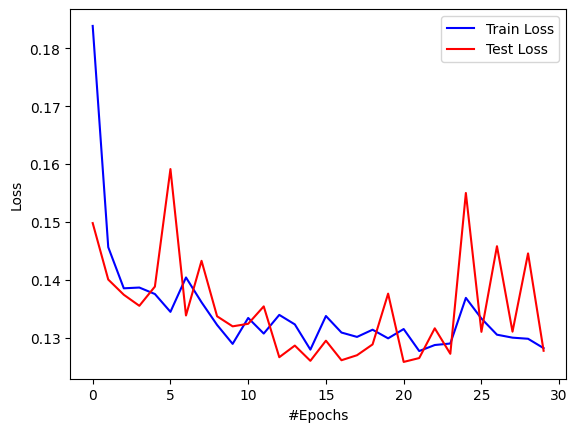

In [ ]:
model = lucky_classifier()

In [ ]:
print(isLucky(model, mnist_testing_data[0]))
print(mnist_testing_labels[0])
print(mnist_testing_label_lucky[0])

tensor([[880.6438]])
7
[1.]


In [ ]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 51786/60000 (86.3%)

Test Set: Accuracy: 8604/10000 (86.0%)


Loaded Data
Epoch [1/30], Train Loss: 0.1740, Test Loss: 0.1502
Epoch [6/30], Train Loss: 0.1347, Test Loss: 0.1303
Epoch [11/30], Train Loss: 0.1325, Test Loss: 0.1318
Epoch [16/30], Train Loss: 0.1342, Test Loss: 0.1314
Epoch [21/30], Train Loss: 0.1327, Test Loss: 0.1518
Epoch [26/30], Train Loss: 0.1331, Test Loss: 0.1245


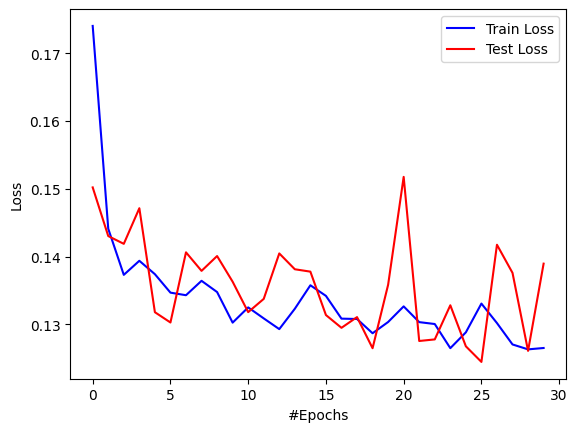

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size) 
testing_generator_3 = torch.utils.data.DataLoader(testing_dataset_3, batch_size=batch_size) 
testing_generator_7 = torch.utils.data.DataLoader(testing_dataset_7, batch_size=batch_size) 
testing_generator_8 = torch.utils.data.DataLoader(testing_dataset_8, batch_size=batch_size) 

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, testing_generator, "Test Set")
computeLabelAccuracy(model, testing_generator_3, "Test Set on 3's")
computeLabelAccuracy(model, testing_generator_7, "Test Set on 7's")
computeLabelAccuracy(model, testing_generator_8, "Test Set on 8's")


Test Set: Accuracy: 8604/10000 (86.0%)

Test Set on 3's: Accuracy: 8142/10000 (81.4%)

Test Set on 7's: Accuracy: 8198/10000 (82.0%)

Test Set on 8's: Accuracy: 7532/10000 (75.3%)


# **Part 2: Binary Classifier - Set Up**

In [ ]:
mnist_training_data = mnist.data.values[0:45000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:45000] 
mnist_validation_data_1 = mnist.data.values[45000:52500,:] #Test on the rest
mnist_validation_labels_1 = mnist.target.values[45000:52500] 
mnist_validation_data_2 = mnist.data.values[52500:60000,:] #Test on the rest
mnist_validation_labels_2 = mnist.target.values[52500:60000] 
mnist_testing_data = mnist.data.values[60000:,:]
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
three_and_seven = np.logical_or(mnist_training_labels=='3', mnist_training_labels == '7')
mnist_training_label_lucky = np.expand_dims(1.0*(np.logical_or(three_and_seven, mnist_training_labels == '8')),1)

test_three_and_seven = np.logical_or(mnist_testing_labels=='3', mnist_testing_labels == '7')
mnist_testing_label_lucky = np.expand_dims(1.0*(np.logical_or(test_three_and_seven, mnist_testing_labels == '8')),1)

test_three_and_seven = np.logical_or(mnist_validation_labels_1=='3', mnist_validation_labels_1 == '7')
mnist_validation_label_lucky_1 = np.expand_dims(1.0*(np.logical_or(test_three_and_seven, mnist_validation_labels_1 == '8')),1)

test_three_and_seven = np.logical_or(mnist_validation_labels_2=='3', mnist_validation_labels_2 == '7')
mnist_validation_label_lucky_2 = np.expand_dims(1.0*(np.logical_or(test_three_and_seven, mnist_validation_labels_2 == '8')),1)

In [ ]:
mnist_training_data /= 255
mnist_testing_data /= 255
mnist_validation_data_1 /= 255
mnist_validation_data_2 /= 255

In [ ]:
mnist_training_data.shape

(45000, 784)

In [ ]:
mnist_testing_label_lucky.shape

(10000, 1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Loaded Data
Epoch [1/30], Train Loss: 0.1849, Test Loss: 0.1440
Epoch [6/30], Train Loss: 0.1345, Test Loss: 0.1328
Epoch [11/30], Train Loss: 0.1326, Test Loss: 0.1302
Epoch [16/30], Train Loss: 0.1282, Test Loss: 0.1385
Epoch [21/30], Train Loss: 0.1344, Test Loss: 0.1280
Epoch [26/30], Train Loss: 0.1287, Test Loss: 0.1248


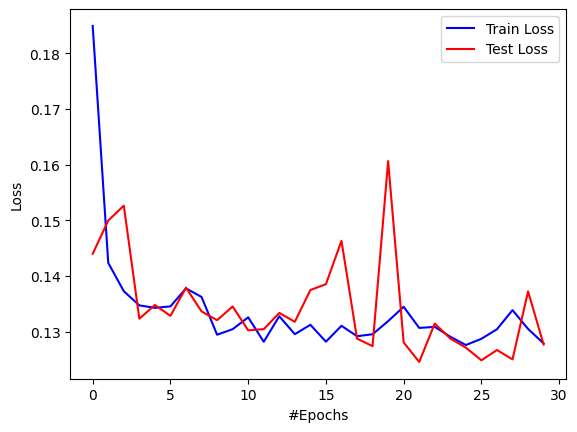

In [ ]:
model= lucky_classifier()

# **Part 2: Binary Classifier - Results**

I used KNN. Again, I made sure the labels were 1 if it was lucky and 0 if not. Also, I split the data into testing, training and validation sets. I tested a range of k's using the validation data to get the most optimal k, which is 24.

Quality of model:
* Validation Set: Accuracy: 0.9762
* Test Set: Accuracy: 0.9788

In [ ]:
#finding optimal k
for k in range(1,41, 10):
  neigh = KNeighborsClassifier(n_neighbors = k,  algorithm = 'ball_tree')
  neigh.fit(mnist_training_data, np.ravel(mnist_training_label_lucky))
  pred = neigh.predict(mnist_validation_data_1)
  score = accuracy(pred, mnist_validation_label_lucky_1)
  pred = neigh.predict(mnist_validation_data_2)
  score += accuracy(pred, mnist_validation_label_lucky_2)
  score /= 2
  print("\n")
  print(k)
  print(score)



1
0.9088


11
0.9478


21
0.9501333333333333


31
0.9497333333333333


In [ ]:
#finding optimal k
for k in range(15,26, 3):
  neigh = KNeighborsClassifier(n_neighbors = k,  algorithm = 'ball_tree')
  neigh.fit(mnist_training_data, np.ravel(mnist_training_label_lucky))
  pred = neigh.predict(mnist_validation_data_1)
  score = accuracy(pred, mnist_validation_label_lucky_1)
  pred = neigh.predict(mnist_validation_data_2)
  score += accuracy(pred, mnist_validation_label_lucky_2)
  score /= 2
  print("\n")
  print(k)
  print(score)



15
0.9792666666666667


18
0.9783333333333333


21
0.9770000000000001


24
0.9762


In [ ]:
neigh = KNeighborsClassifier(n_neighbors = 24, algorithm = 'ball_tree')
neigh.fit(mnist_training_data, mnist_training_label_lucky.squeeze())
pred = neigh.predict(mnist_testing_data)
print(accuracy(pred, mnist_testing_label_lucky))

0.9788


**2a.**

The KNN model performed the best.
KNN Results:
* AUC: 0.9704745224406705
* Precision [0.97853107 0.97945205]
* Recall [0.99141385 0.94953519]
* F1 [0.98493034 0.96426163]

Logistic Regression Results:
* AUC: 0.9060386007962046
* Precision [0.89867226 0.80386643]
* Recall [0.92014883 0.75929615]
* F1 [0.90928374 0.78094588]

AUC: 0.9060386007962046
Precision [0.89867226 0.80386643]
Recall [0.92014883 0.75929615]
F1 [0.90928374 0.78094588]
Count [6988 3012]


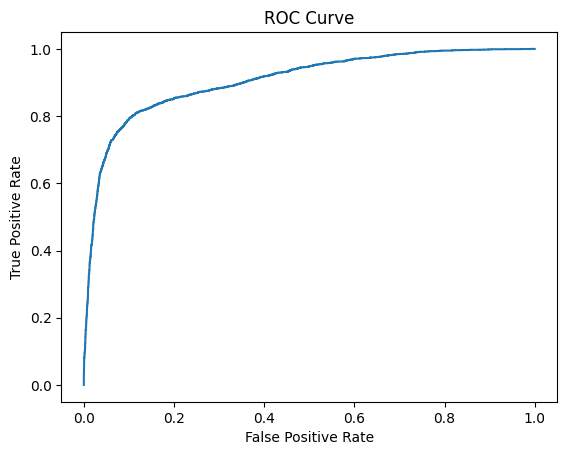

In [ ]:
#linear regression model
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_lucky,preds, pos_label = 1)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_lucky,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

AUC: 0.9704745224406705
Precision [0.97853107 0.97945205]
Recall [0.99141385 0.94953519]
F1 [0.98493034 0.96426163]
Count [6988 3012]


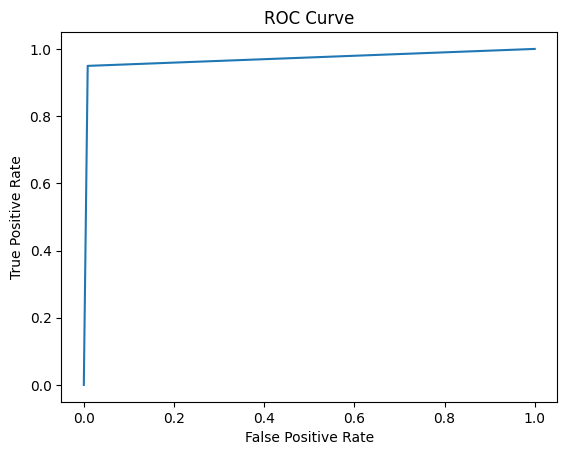

In [ ]:
#knn model
preds = pred 
fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_lucky,preds, pos_label = 1)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_lucky,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

# **Part 3: Digit Classification - Set Up**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

torch.set_printoptions(sci_mode=False)

In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
loss_function_sum = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
mnist_training_data = mnist.data.values[0:45000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:45000] 
mnist_validation_data = mnist.data.values[45000:60000,:] #Test on the rest
mnist_validation_labels = mnist.target.values[45000:60000] 
mnist_testing_data = mnist.data.values[60000:,:]
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()
mnist_validation_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_validation_labels.to_numpy().astype(int))).long()).numpy()

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)
validation_dataset = NumpyDataset(mnist_validation_data,mnist_validation_labels_catigories)

In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution 
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution 
  test_loss = 0
  num_batches = 0
  with torch.no_grad(): 
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):                           
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
      
  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses, layer_1, layer_2):  #For binary predictions numClasses = 1 is fine
        super().__init__()          
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, layer_1)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(layer_1, layer_2)
        self.linear3 = nn.Linear(layer_2, numClasses)
    
    def forward(self, x):           
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

# **Part 3: Digit Classification - Results**

I designed my neural network by trying a few different values for the layers. The best one I found was to have it condense the data into 1000 values, then 100, then to the number of classes (10). I also split into training, testing and validation sets.
Performance:
* Train Set: Accuracy: 44970/45000 (99.9%)

* Validation Set: Accuracy: 14676/15000 (97.8%)
* Test Set: Accuracy: 9813/10000 (98.1%)

In [ ]:
def multi_layer_nn(layer_1, layer_2, training, testing):
  #Training parameters
  num_epochs = 30
  print_interval = 5
  learning_rate = 0.001
  batch_size = 200

  #MNIST images are 28x28
  image_w = 28
  image_h = 28

  #Create model
  predModel = Classifier_3Layers(image_w, image_h, 10, layer_1, layer_2)

  #Set optimizer and loss function
  model = predModel;
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
  loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

  #Load the data, and split it into batches
  # training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  # testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size) 
  training_generator = torch.utils.data.DataLoader(training, batch_size=batch_size, shuffle=True)
  testing_generator = torch.utils.data.DataLoader(testing, batch_size=batch_size) 

  print("Loaded Data")

  trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
  computeLabelAccuracy(model, training_generator, "Train Set")
  computeLabelAccuracy(model, testing_generator, "Test Set")
  return model

Loaded Data
Epoch [1/30], Train Loss: 1.0189, Test Loss: 0.4209
Epoch [6/30], Train Loss: 0.1888, Test Loss: 0.2064
Epoch [11/30], Train Loss: 0.1413, Test Loss: 0.1792
Epoch [16/30], Train Loss: 0.1182, Test Loss: 0.1754
Epoch [21/30], Train Loss: 0.1022, Test Loss: 0.1663
Epoch [26/30], Train Loss: 0.0889, Test Loss: 0.1681

Train Set: Accuracy: 44045/45000 (97.9%)

Test Set: Accuracy: 9543/10000 (95.4%)


Classifier_3Layers(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=10, bias=True)
)

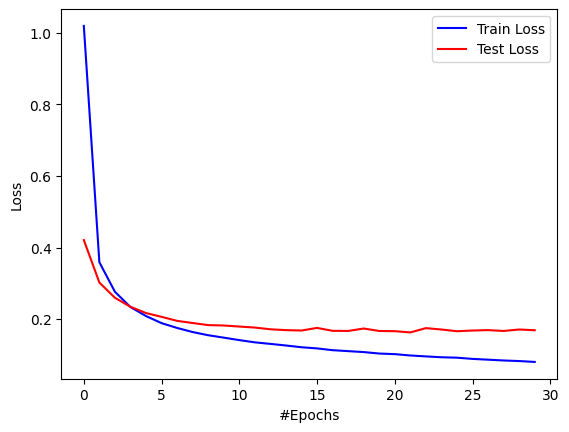

In [ ]:
#trying different values to see the best
multi_layer_nn(20, 15, training_dataset, testing_dataset)

Loaded Data
Epoch [1/30], Train Loss: 0.6124, Test Loss: 0.2374
Epoch [6/30], Train Loss: 0.0692, Test Loss: 0.1079
Epoch [11/30], Train Loss: 0.0262, Test Loss: 0.1068
Epoch [16/30], Train Loss: 0.0098, Test Loss: 0.1136
Epoch [21/30], Train Loss: 0.0084, Test Loss: 0.1409
Epoch [26/30], Train Loss: 0.0016, Test Loss: 0.1386

Train Set: Accuracy: 45000/45000 (100.0%)

Test Set: Accuracy: 14630/15000 (97.5%)


Classifier_3Layers(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
)

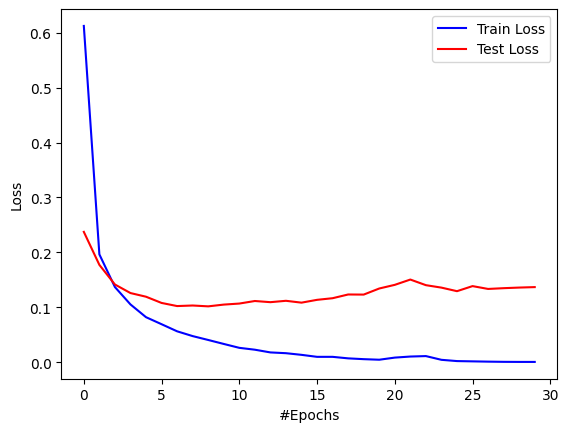

In [ ]:
multi_layer_nn(100, 50, training_dataset, validation_dataset)

Loaded Data
Epoch [1/30], Train Loss: 0.3318, Test Loss: 0.1334
Epoch [6/30], Train Loss: 0.0229, Test Loss: 0.1100
Epoch [11/30], Train Loss: 0.0100, Test Loss: 0.1281
Epoch [16/30], Train Loss: 0.0067, Test Loss: 0.1171
Epoch [21/30], Train Loss: 0.0064, Test Loss: 0.1269
Epoch [26/30], Train Loss: 0.0274, Test Loss: 0.1644

Train Set: Accuracy: 44998/45000 (100.0%)

Test Set: Accuracy: 14682/15000 (97.9%)


Classifier_3Layers(
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

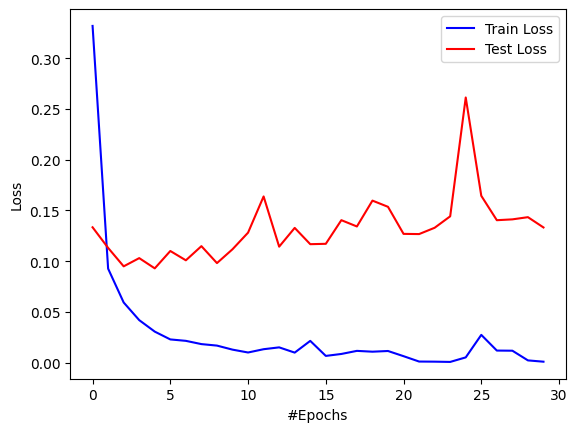

In [ ]:
multi_layer_nn(1000, 100, training_dataset, validation_dataset)  #Best one!!

Loaded Data
Epoch [1/30], Train Loss: 0.3437, Test Loss: 0.1580
Epoch [6/30], Train Loss: 0.0241, Test Loss: 0.1002
Epoch [11/30], Train Loss: 0.0144, Test Loss: 0.1347
Epoch [16/30], Train Loss: 0.0101, Test Loss: 0.1651
Epoch [21/30], Train Loss: 0.0146, Test Loss: 0.1409
Epoch [26/30], Train Loss: 0.0063, Test Loss: 0.1423

Train Set: Accuracy: 44964/45000 (99.9%)

Test Set: Accuracy: 14677/15000 (97.8%)


Classifier_3Layers(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=10, bias=True)
)

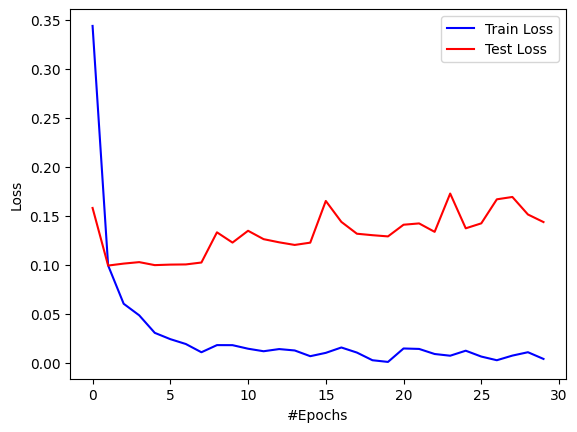

In [ ]:
multi_layer_nn(500, 200, training_dataset, validation_dataset) 

Loaded Data
Epoch [1/30], Train Loss: 0.3383, Test Loss: 0.1197
Epoch [6/30], Train Loss: 0.0201, Test Loss: 0.0740
Epoch [11/30], Train Loss: 0.0142, Test Loss: 0.1026
Epoch [16/30], Train Loss: 0.0106, Test Loss: 0.1251
Epoch [21/30], Train Loss: 0.0160, Test Loss: 0.1311
Epoch [26/30], Train Loss: 0.0064, Test Loss: 0.1197

Train Set: Accuracy: 44960/45000 (99.9%)

Test Set: Accuracy: 9802/10000 (98.0%)


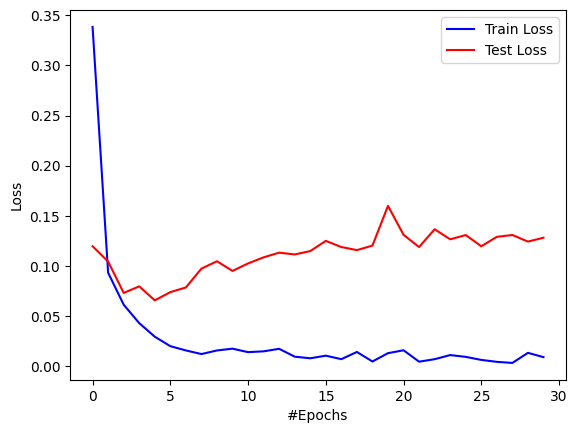

In [ ]:
mnn_model = multi_layer_nn(1000, 100, training_dataset,testing_dataset) #testing data

# **Part 4: Visual Analysis - Set Up**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

torch.set_printoptions(sci_mode=False)

In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
loss_function_sum = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist_training_data = mnist.data.values[0:45000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:45000] 
mnist_validation_data = mnist.data.values[45000:60000,:] #Test on the rest
mnist_validation_labels = mnist.target.values[45000:60000] 
mnist_testing_data = mnist.data.values[60000:,:]
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution 
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution 
  test_loss = 0
  num_batches = 0
  with torch.no_grad(): 
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):                           
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
      
  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
type(mnist_training_labels)

pandas.core.arrays.categorical.Categorical

In [ ]:
mnist_training_labels.to_numpy()

array(['5', '0', '4', ..., '8', '4', '5'], dtype=object)

In [ ]:
mnist_training_labels.to_numpy().astype(int)

array([5, 0, 4, ..., 8, 4, 5])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int))

tensor([5., 0., 4.,  ..., 8., 4., 5.])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int)).long()

tensor([5, 0, 4,  ..., 8, 4, 5])

In [ ]:
F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()
mnist_validation_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_validation_labels.to_numpy().astype(int))).long()).numpy()

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)
validation_dataset = NumpyDataset(mnist_validation_data,mnist_validation_labels_catigories)

In [ ]:
class Classifier_3Lyares(nn.Module):
    def __init__(self, img_w, img_h, numClasses, layer_1, layer_2):  #For binary predictions numClasses = 1 is fine
        super().__init__()          
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, layer_1)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(layer_1, layer_2)
        self.linear3 = nn.Linear(layer_2, numClasses)
    
    def forward(self, x):           
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

Loaded Data
Epoch [1/30], Train Loss: 2.0012, Test Loss: 0.4694
Epoch [6/30], Train Loss: 0.1251, Test Loss: 0.1838
Epoch [11/30], Train Loss: 0.0477, Test Loss: 0.1793
Epoch [16/30], Train Loss: 0.0457, Test Loss: 0.2174
Epoch [21/30], Train Loss: 0.0465, Test Loss: 0.1913
Epoch [26/30], Train Loss: 0.0351, Test Loss: 0.2076


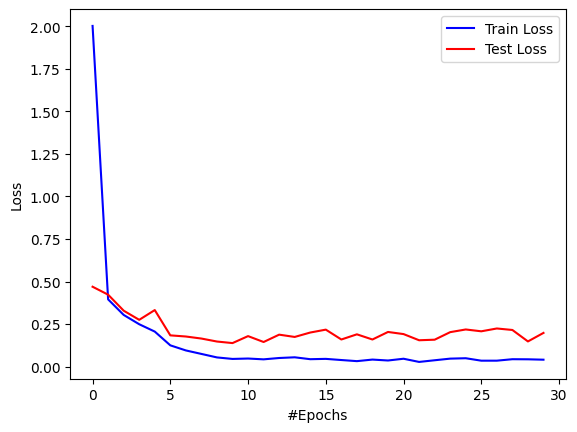

In [ ]:
# def multi_layer_nn(training, testing, layer_1, layer_2):#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

predModel = Classifier_3Lyares(image_w, image_h, 10, 1000, 100)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

  #Load the data, and split it into batches
  # training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  # testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size) 

training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000) 

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)


In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 44614/45000 (99.1%)

Train Set: Accuracy: 9713/10000 (97.1%)


# **Part 4: Visual Analysis - Results**

**4a.**

I think for the most part, these are good examples. Specifically, I think the 3, 4, 5, 6 and 7 images were great examples. The other images were clear what digits they were, but were slightly off in my opinion. For example, the 0 has that bump at the top which I could see being confused with a 6. The 2's bottom is a little long, and the 1, 8 and 9 are a bit slanted.

In [ ]:
import math
def max_conf(networkModel, data_loader):
  # true_labels = np.argmax(labels,axis =1)
  # output = networkModel(data)

  confidences = [-math.inf] * 10
  image_index = [-math.inf] * 10
  # print(true_labels.shape)
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      for i in range (len(true_labels)):
        #pred = output[i,:]
        actual_label = int(true_labels[i])
        curr_confidence = pred[actual_label]

        if int(pred[i]) == actual_label:
          if curr_confidence > confidences[actual_label]:
              confidences[actual_label] = curr_confidence
              image_index[actual_label] = i

  return image_index

In [ ]:
image_index = max_conf(model, testing_generator)

0


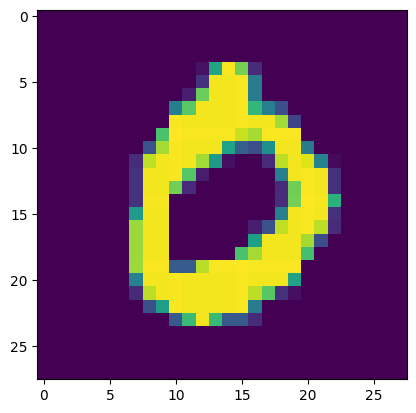

In [ ]:
#0
pixels = mnist_testing_data[image_index[0]]  # 1x784
print(mnist_testing_labels[image_index[0]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

1


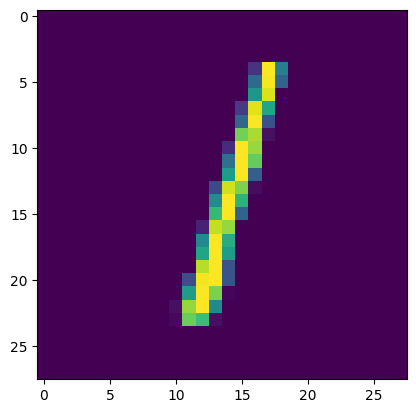

In [ ]:
#1
pixels = mnist_testing_data[image_index[1]]  # 1x784
print(mnist_testing_labels[image_index[1]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

2


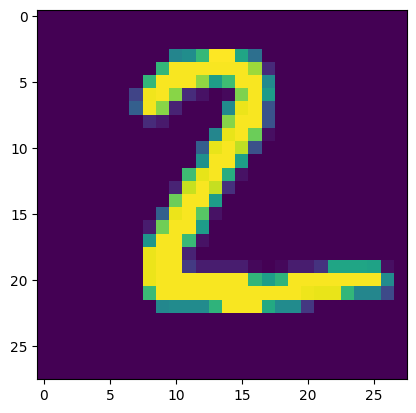

In [ ]:
#2
pixels = mnist_testing_data[image_index[2]]  # 1x784
print(mnist_testing_labels[image_index[2]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

3


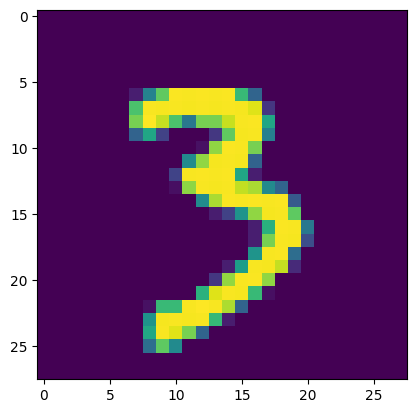

In [ ]:
#3
pixels = mnist_testing_data[image_index[3]]  # 1x784
print(mnist_testing_labels[image_index[3]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

4


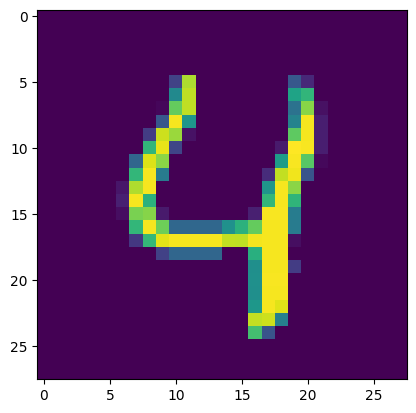

In [ ]:
#4
pixels = mnist_testing_data[image_index[4]]  # 1x784
print(mnist_testing_labels[image_index[4]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

5


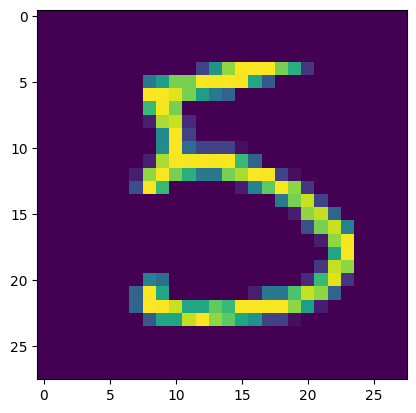

In [ ]:
#5
pixels = mnist_testing_data[image_index[5]]  # 1x784
print(mnist_testing_labels[image_index[5]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

6


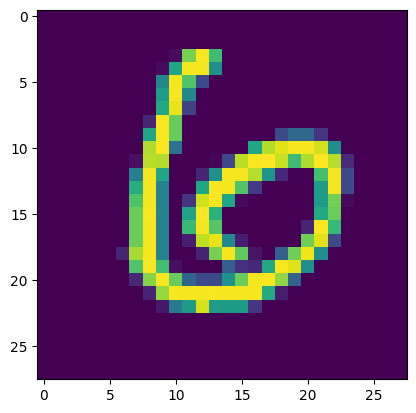

In [ ]:
#6
pixels = mnist_testing_data[image_index[6]]  # 1x784
print(mnist_testing_labels[image_index[6]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

7


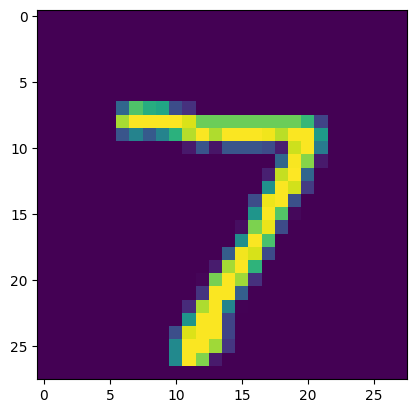

In [ ]:
#7
pixels = mnist_testing_data[image_index[7]]  # 1x784
print(mnist_testing_labels[image_index[7]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

8


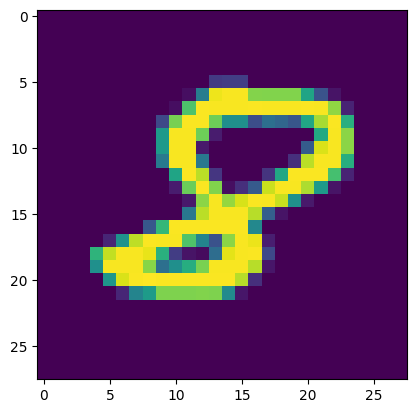

In [ ]:
#8
pixels = mnist_testing_data[image_index[8]]  # 1x784
print(mnist_testing_labels[image_index[8]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

9


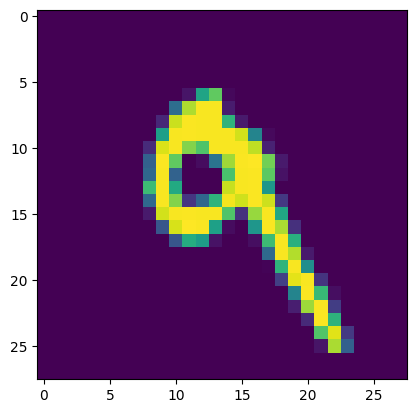

In [ ]:
#9
pixels = mnist_testing_data[image_index[9]]  # 1x784
print(mnist_testing_labels[image_index[9]])
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

**4b.**

Most common cases of misclassification:
* 9 predicted as a 4 (0.04)
* 5 predicted as a 3 (0.02)
* 9 predicted as a 7 (0.01)
* 8 predicted as a 6 (0.01)
* 4 predicted as a 2 (0.01)

Text(70.72222222222221, 0.5, 'Predicted Class')

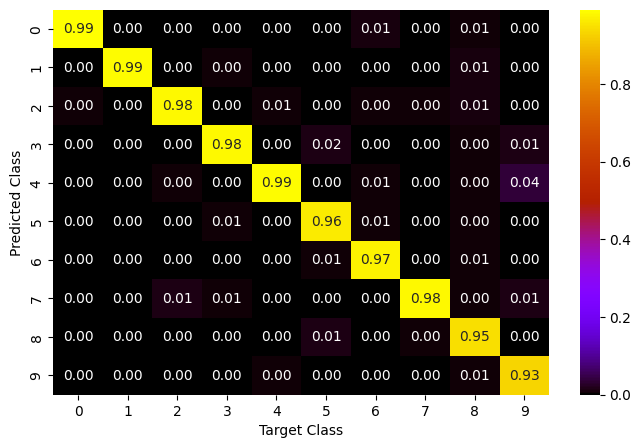

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

In [ ]:
def mispredicted(networkModel, data_loader):
  index_9_4 = -1
  index_5_3 = -1
  index_9_7 = -1
  index_8_0 = -1
  index_6_5 = -1
  # print(true_labels.shape)
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      for i in range (len(true_labels)):
        #pred = output[i,:]
        actual_label = int(true_labels[i])
        curr_confidence = pred[actual_label]
        pred_label = int(pred[i])
        if actual_label == 9 and pred_label == 4:
          index_9_4 = i
        if actual_label == 5 and pred_label == 3:
          index_5_3 = i
        if actual_label == 9 and pred_label == 7:
          index_9_7 = i
        if actual_label == 8 and pred_label == 0:
          index_8_0 = i
        if actual_label == 6 and pred_label == 5:
          index_6_5 = i
  return [index_9_4, index_5_3, index_9_7, index_8_0, index_6_5]

In [ ]:
image_indices = mispredicted(model, testing_generator)

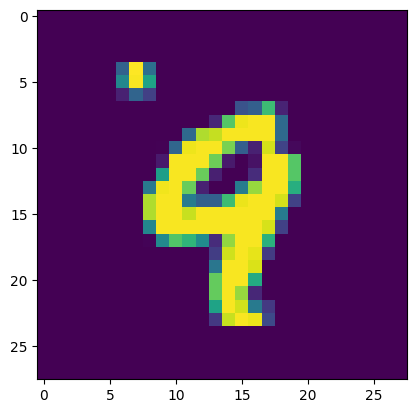

In [ ]:
#actual is 9 but predicted to be a 4
pixels = mnist_testing_data[image_indices[0]]  # 1x784
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

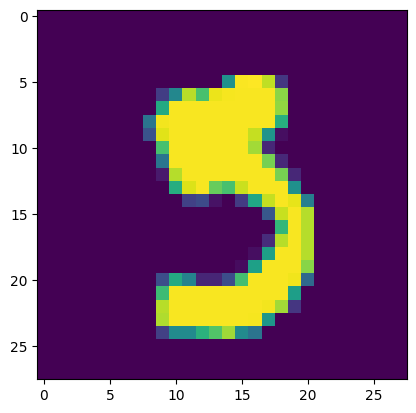

In [ ]:
#actual is 5 but predicted to be a 3
pixels = mnist_testing_data[image_indices[1]]  # 1x784
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

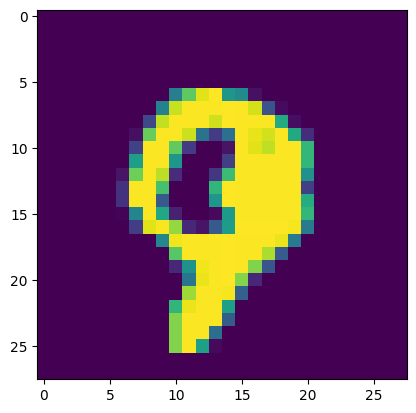

In [ ]:
#actual is 9 but predicted to be a 7
pixels = mnist_testing_data[image_indices[2]]  # 1x784
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

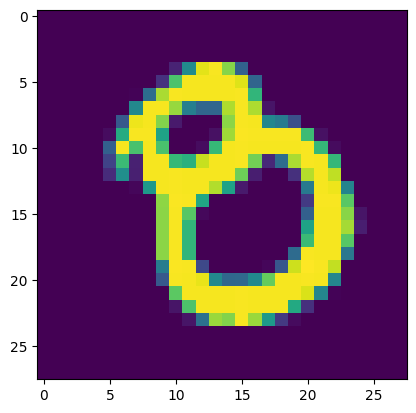

In [ ]:
#actual is 8 but predicted to be a 0
pixels = mnist_testing_data[image_indices[3]]  # 1x784
pixels = pixels.reshape(28,28)
plt.imshow(pixels)

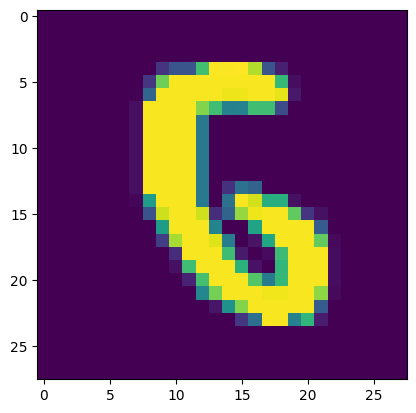

In [ ]:
#actual is 6 but predicted to be a 5
pixels = mnist_testing_data[image_indices[4]]  # 1x784
pixels = pixels.reshape(28,28)
plt.imshow(pixels)